# **Project 3: Team Norman Borlaug**

## Vitamin A Policy

#### Group Members:
> Mary  -  marylaska@berkeley.edu <br>
> Jack - jackpollard@berkeley.edu<br>
> Jocelyn - jocelynvelazquez@berkeley.edu <br>
> Vivian - yumeng.zhang0502@berkeley.edu <br>
> Steven -  k1519632@berkeley.edu <br>


## Project Setup

In [1]:
#import packages

In [2]:
!pip install -r requirements.txt

  Using cached cfedemands-0.6.4.dev0-py2.py3-none-any.whl.metadata (1.6 kB)
  Using cached ConsumerDemands-0.4.3.dev0-py2.py3-none-any.whl.metadata (1.2 kB)
  Using cached eep153_tools-0.12.4-py2.py3-none-any.whl.metadata (363 bytes)
  Using cached python_gnupg-0.5.4-py2.py3-none-any.whl.metadata (2.0 kB)
  Using cached gspread_pandas-3.3.0-py2.py3-none-any.whl.metadata (10 kB)
  Using cached fsspec-2025.3.2-py3-none-any.whl.metadata (11 kB)
Using cached cfedemands-0.6.4.dev0-py2.py3-none-any.whl (45 kB)
Using cached ConsumerDemands-0.4.3.dev0-py2.py3-none-any.whl (12 kB)
Using cached eep153_tools-0.12.4-py2.py3-none-any.whl (4.9 kB)
Using cached python_gnupg-0.5.4-py2.py3-none-any.whl (21 kB)
Using cached gspread_pandas-3.3.0-py2.py3-none-any.whl (27 kB)
Using cached fsspec-2025.3.2-py3-none-any.whl (194 kB)
  Attempting uninstall: gspread_pandas
    Found existing installation: gspread-pandas 2.2.3
    Uninstalling gspread-pandas-2.2.3:
      Successfully uninstalled gspread-pandas-2

In [3]:
import pandas as pd
import numpy as np
from eep153_tools.sheets import read_sheets
import cfe.regression as rgsn
import warnings

In [4]:
warnings.filterwarnings('ignore')

# [A] Choice of a dataset and regression set-up

We chose the Uganda dataset because it was one of the most comprehensive in our previous project, offering detailed yearly data. We also identified a relevant nutrition policy in Uganda to analyze, allowing us to assess its impact and suggest policy improvements.

In [5]:
uganda_data = '1yFWlP5N7Aowaj6t2roRSFFUC50aFD-RLBGfzGtqLl0w'

In [6]:
import cfe

# Define your InputFiles dictionary.

# --------------------------------------------
# YEAR  (2009-10) and Run Cell
#---------------------------------------------

InputFiles = {
    'Expenditures': ('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','Expenditures (2009-10)'), #CHANGE YEAR HERE 2013-14 OR 2019-20
    'Prices': ('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','Prices'),
    'HH Characteristics': ('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','HH Characteristics'),
    'FCT': ('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','FCT'),
    'RDI': ('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','RDI'),
}


def get_clean_sheet(key, sheet=None):
    """
    Read a sheet from Google Sheets, clean column names and duplicates.
    """
    df = read_sheets(key, sheet=sheet)
    # Strip whitespace from column names.
    df.columns = [c.strip() for c in df.columns.tolist()]
    # Remove duplicate columns, keeping the first occurrence.
    df = df.loc[:, ~df.columns.duplicated(keep='first')]
    # Drop columns that start with 'Unnamed'
    df = df.drop([col for col in df.columns if col.startswith('Unnamed')], axis=1)
    # Drop duplicate rows based on the index.
    df = df.loc[~df.index.duplicated(), :]
    # Also drop any completely duplicate rows.
    df = df.drop_duplicates()
    return df


def load_data(InputFiles):
    """
    Load and preprocess the Expenditures, HH Characteristics, Prices, FCT, and RDI data.
    Returns:
      x: Expenditures DataFrame indexed by ['i','t','m'] with columns 'j'
      z: Household characteristics DataFrame indexed by ['i','t','m']
      p, fct, rdi: Other data sets (if needed for later analysis)
    """
    # Get expenditures
    x = get_clean_sheet(InputFiles['Expenditures'][0],
                        sheet=InputFiles['Expenditures'][1])
    if 'm' not in x.columns:
        x['m'] = 1
    x["i"] = x["i"].astype(str)
    x = x.set_index(['i','t','m'])
    x.columns.name = 'j'
    x = x.apply(lambda col: pd.to_numeric(col, errors='coerce'))
    x = x.replace(0, np.nan)
    
    # Get HH Characteristics
    z = get_clean_sheet(InputFiles['HH Characteristics'][0],
                        sheet=InputFiles['HH Characteristics'][1])
    if 'm' not in z.columns:
        z['m'] = 1
    z = z.set_index(['i','t','m'])
    z.columns.name = 'k'
    z = z.apply(lambda col: pd.to_numeric(col, errors='coerce'))
    
    # Get Prices (if needed later)
    p = get_clean_sheet(InputFiles['Prices'][0],
                        sheet=InputFiles['Prices'][1])
    if 'm' not in p.columns:
        p['m'] = 1
    p = p.set_index(['t','m'])
    p.columns.name = 'j'
    p = p.apply(lambda col: pd.to_numeric(col, errors='coerce'))
    p = p.replace(0, np.nan)
    
    # Get FCT
    fct = get_clean_sheet(InputFiles['FCT'][0],
                          sheet=InputFiles['FCT'][1])
    fct = fct.set_index('j')
    fct.columns.name = 'n'
    fct = fct.apply(lambda col: pd.to_numeric(col, errors='coerce'))
    
    # Get RDI
    rdi = get_clean_sheet(InputFiles['RDI'][0],
                          sheet=InputFiles['RDI'][1])
    rdi = rdi.set_index('n')
    rdi.columns.name = 'k'
    
    return x, z, p, fct, rdi


def prepare_expenditures_for_regression(x):
    """
    Convert the Expenditures DataFrame to a 1D Series (y) for regression.
    This function aggregates duplicate (i,t,m,j) combinations using the mean,
    then takes the natural log.
    """
    # Stack the expenditures so that columns (j) become part of the index.
    # Reset index to make all index levels into columns.
    df_long = x.stack().reset_index(name='expenditure')
    # Now, if duplicates exist in (i,t,m,j), aggregate them.
    df_agg = df_long.groupby(['i', 't', 'm', 'j'])['expenditure'].mean().reset_index()
    # Set the multi-index again.
    y = df_agg.set_index(['i', 't', 'm', 'j'])['expenditure']
    # Take the log of expenditures.
    y_log = np.log(y)
    return y_log


def run_regression(x, z):
    """
    Prepare the data and run the regression of log(expenditures) on household characteristics.
    Returns the regression result from cfe.
    """
    # Prepare y (dependent variable)
    y_log = prepare_expenditures_for_regression(x)
    
    # Run the regression.
    result = cfe.Regression(y=y_log, d=z)
    return result


# =============================================================================
# Call of the functions:
# =============================================================================

# Load all data.
x, z, p, fct, rdi = load_data(InputFiles)

# preview of data:
#display(x.head())
#display(z.head())
#display(p.head())
#display(fct.head())
#display(rdi.head())

# Run  regression.
result = run_regression(x, z)

# Display sorted regression coefficients.
beta_sorted = result.get_beta().sort_values(ascending=False)
#print(beta_sorted.head(20))


In [7]:
result.to_pickle('./foo.pickle')

In [8]:
import cfe

result = cfe.read_pickle('foo.pickle')  # Get persistent result saved above...

xhat = result.predicted_expenditures()

# Expenditures divided by prices/kg gives quantities in kgs...
qhat = (xhat.unstack('j')/p).dropna(how='all')

# Drop missing columns
qhat = qhat.loc[:,qhat.count()>0]

In [9]:
use = fct.index.intersection(qhat.columns)


nutrients = qhat[use]@fct.loc[use,:]
nutrients.mean()    # NB: Nutrients are for past /week/ for entire household. (Depends on dataset)

n
Energy          106476.993449
Protein           2165.478473
Fiber             2009.072054
Folate           21064.797450
Calcium          28684.337182
Carbohydrate     19616.140712
Iron               835.493006
Niacin             753.466964
Riboflavin          66.299184
Thiamin             77.429589
Vitamin A        17935.227646
Vitamin B-12        68.797926
Vitamin B-6        170.007659
Vitamin C        14992.000232
Zinc               398.351343
dtype: float64

In [10]:
yhat = result.get_predicted_log_expenditures()

# [A] Estimate Demand System

### Setting up demand system from project 3

In [11]:

def process_data_per_year(uganda_data, year):
    # --- Food Expenditures ---
    sheet_expend = f"Food Expenditures ({year})"
    x = read_sheets(uganda_data, sheet=sheet_expend)
    x["i"] = x["i"].astype(str)
    x = x.set_index(['i', 't', 'm', 'j']).squeeze()
    
    # --- Food Prices ---
    sheet_prices = f"Food Prices ({year})"
    p = read_sheets(uganda_data, sheet=sheet_prices).set_index(['t', 'm', 'j', 'u'])
    p = p.groupby(['t', 'm', 'j', 'u']).median()
    
    # Directly select prices in kilograms
    p = p.xs('Kg', level='u').squeeze().unstack('j')
    # Align to only the goods you estimated
    p = p[x.index.levels[-1]].T

    # --- Household Characteristics ---
    d = read_sheets(uganda_data, sheet="Household Characteristics")
    d = d[d.t == year]
    d.columns.name = 'k'
    d = d.replace(np.nan, 0)
    d.set_index(['i', 't', 'm'], inplace=True)
    
    # --- Expenditures Processing ---
    x = x.T.groupby(['i', 't', 'm', 'j']).sum()
    x = x.replace(0, np.nan)
    y = np.log(x)
    
    return x, y, d


# --------------------------------------------
# YEAR (2009-10) and Run Cell
#---------------------------------------------
x, y, d = process_data_per_year(uganda_data,"2009-10")

#print("Food Expenditures (x)")
#display(x.head())

#print("Household Characteristics (d)")
#display(d.head())

#print("Log of Expenditures (y)")
#isplay(y.head())

In [12]:
result.predicted_expenditures()

i           t        m        j             
1013000201  2009-10  Central  Beans              2862.805019
                              Beef               5177.391930
                              Bread              2957.838367
                              Cabbages            725.187395
                              Cassava            2495.331637
                                                    ...     
4193003510  2009-10  Western  Sugar              5828.781737
                              Sweet Bananas      5298.538559
                              Sweet Potatoes    14762.647172
                              Tea                 750.807756
                              Tomatoes           2401.653351
Length: 96530, dtype: float64

In [13]:
result = rgsn.Regression(y=y,d=d)

In [14]:
beta = result.get_beta()
#beta.head

In [15]:
gamma = result.get_gamma()
#gamma.head

### Saving Result

In [16]:
result.to_pickle('uganda_estimates_2009.rgsn')

In [17]:
import cfe
result = cfe.regression.read_pickle('uganda_estimates_2009.rgsn')


#### Reference Prices

In [18]:
col_prices = p.mean(axis=0)

pbar = col_prices.groupby(level='j').mean()

# Keep only the goods you have betas for, fill missing with 1
pbar = pbar.reindex(result.beta.index).fillna(1)

def my_prices(p0, j, p=pbar):
    """
    Change price of jth good to p0, holding other prices fixed.
    """
    p = p.copy()
    p.loc[j] = p0
    return p


#### Budgets

In [19]:
import numpy as np

xhat = result.predicted_expenditures()

# Total food expenditures per household
xbar = xhat.groupby(['i','t','m']).sum()

# Reference budget
xref = xbar.quantile(0.5)  # Household at 0.5 quantile is median

#### Food Quantities 

In [20]:
qhat = (xhat.unstack('j')/pbar).dropna(how='all')

# Drop missing columns
qhat = qhat.loc[:,qhat.count()>0]

#qhat.head(4)

In [21]:
def my_prices(j,p0,p=pbar):
    """
    Change price of jth good to p0, holding other prices fixed at p.
    """
    p = p.copy()
    p.loc[j] = p0
    return p

### Demands

#### Demand Functions -  how quantity demanded responds to price changes at different budget percentiles.

In [22]:
%matplotlib inline


Text(0.5, 0, 'Quantities of Maize (flour) Demanded')

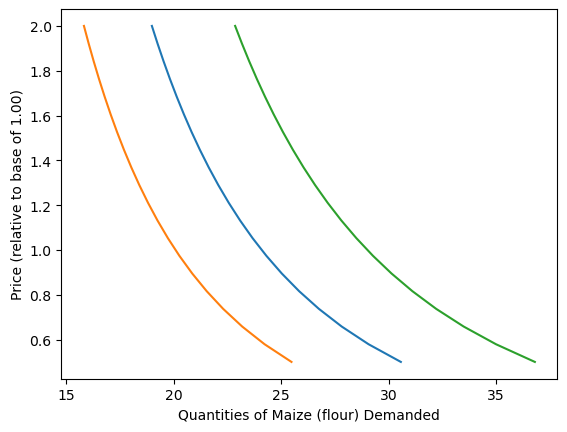

In [23]:
import matplotlib.pyplot as plt

use = 'Maize (flour)'  # CHANGE FOOD TYPE HERE

# Vary prices from 50% to 200% of reference.
scale = np.linspace(.5,2,20)

# Demand  for household at median budget
plt.plot([result.demands(xref,my_prices(use,pbar[use]*s,pbar))[use] for s in scale],scale)

# Demand for household at 25% percentile
plt.plot([result.demands(xbar.quantile(0.25),my_prices(use,pbar[use]*s,pbar))[use] for s in scale],scale)

# Demand for household at 75% percentile
plt.plot([result.demands(xbar.quantile(0.75),my_prices(use,pbar[use]*s,pbar))[use] for s in scale],scale)

plt.ylabel(f"Price (relative to base of {pbar[use]:.2f})")
plt.xlabel(f"Quantities of {use} Demanded")

#### Engel Curves - how expenditure shares change with income.

Text(0.5, 1.0, 'Engel Curves')

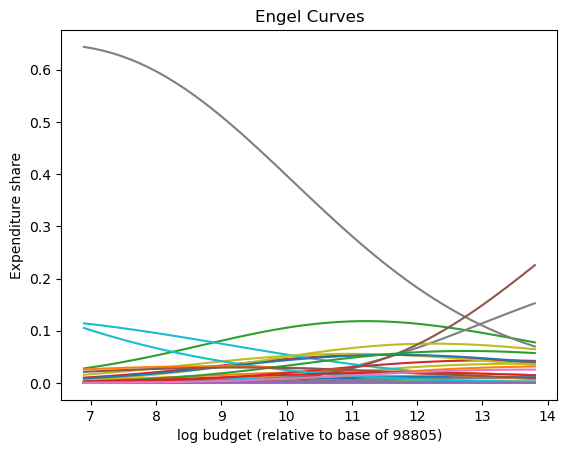

In [24]:
fig,ax = plt.subplots()

scale = np.geomspace(.01,10,50)

ax.plot(np.log(scale*xref),[result.expenditures(s*xref,pbar)/(s*xref) for s in scale])
ax.set_xlabel(f'log budget (relative to base of {xref:.0f})')
ax.set_ylabel(f'Expenditure share')
ax.set_title('Engel Curves')

# [A] Construct Nutrient System

#### Mapping to Nutrients

In [25]:
# Create a new FCT and vector of consumption that only share rows in common:
fct0,c0 = fct.align(qhat.T,axis=0,join='inner')
print(fct0.index)

Index(['Beans (dry)', 'Beans (fresh)', 'Beef', 'Bread', 'Cassava (fresh)',
       'Cooking Oil', 'Dodo', 'Eggs', 'Fresh Fish', 'Ground Nuts (pounded)',
       'Ground Nuts (shelled)', 'Mangos', 'Millet', 'Onions', 'Oranges',
       'Passion Fruits', 'Sim Sim', 'Sorghum', 'Sugar', 'Sweet Bananas',
       'Sweet Potatoes (fresh)', 'Tomatoes'],
      dtype='object', name='j')


In [26]:
N = fct0.T@c0

N.head()  #NB: Uganda quantities are for previous 7 days

i,1013000201,1013000204,1013000206,101300021302,1021000102,1021000108,1021000109,1021000110,1021000111,1021000113,...,4193003208,4193003210,4193003211,4193003212,4193003502,4193003503,4193003504,4193003506,4193003508,4193003510
t,2009-10,2009-10,2009-10,2009-10,2009-10,2009-10,2009-10,2009-10,2009-10,2009-10,...,2009-10,2009-10,2009-10,2009-10,2009-10,2009-10,2009-10,2009-10,2009-10,2009-10
m,Central,Central,Central,Central,Central,Central,Central,Central,Central,Central,...,Western,Western,Western,Western,Western,Western,Western,Western,Western,Western
n,,,,,,,,,,,,,,,,,,,,,
Energy,4.252031e+07,5.085405e+07,4.631386e+07,4.226501e+07,6.485814e+07,6.565379e+07,6.572981e+07,1.001623e+08,8.666973e+07,1.080147e+08,...,6.856346e+07,7.410625e+07,4.951229e+07,4.923411e+07,1.668099e+08,1.077506e+08,4.612827e+07,1.902337e+08,5.090537e+07,1.968943e+08
Protein,2.360851e+06,2.804624e+06,2.535928e+06,2.319010e+06,3.665150e+06,3.611813e+06,3.617967e+06,5.805361e+06,4.511182e+06,5.931056e+06,...,3.843417e+06,4.152106e+06,2.743094e+06,2.650188e+06,8.958145e+06,6.084583e+06,2.580521e+06,1.038551e+07,2.792986e+06,1.090839e+07
Fiber,9.738564e+05,1.187127e+06,9.634684e+05,9.492347e+05,1.439862e+06,1.589965e+06,1.429394e+06,2.240938e+06,2.075486e+06,2.407227e+06,...,1.879746e+06,2.150337e+06,1.319355e+06,1.535968e+06,4.058760e+06,2.682931e+06,1.285451e+06,5.139937e+06,1.433715e+06,5.373515e+06
Folate,2.179079e+07,2.657383e+07,2.198087e+07,2.145122e+07,3.235479e+07,3.677058e+07,3.076339e+07,5.222915e+07,4.593403e+07,5.437240e+07,...,4.564608e+07,5.393257e+07,3.149597e+07,3.824719e+07,9.295312e+07,6.294937e+07,3.075927e+07,1.276604e+08,3.502861e+07,1.332890e+08
Calcium,9.056596e+06,1.096598e+07,9.157368e+06,8.845553e+06,1.355056e+07,1.444042e+07,1.357339e+07,2.084519e+07,1.907664e+07,2.255793e+07,...,1.634820e+07,1.838185e+07,1.163031e+07,1.290669e+07,3.700603e+07,2.429825e+07,1.119422e+07,4.491789e+07,1.237868e+07,4.682171e+07


In [27]:
def nutrient_demand(x,p):
    c = result.demands(x,p)
    fct0,c0 = fct.align(c,axis=0,join='inner')
    N = fct0.T@c0

    N = N.loc[~N.index.duplicated()]
    
    return N

Text(0, 0.5, 'log nutrient')

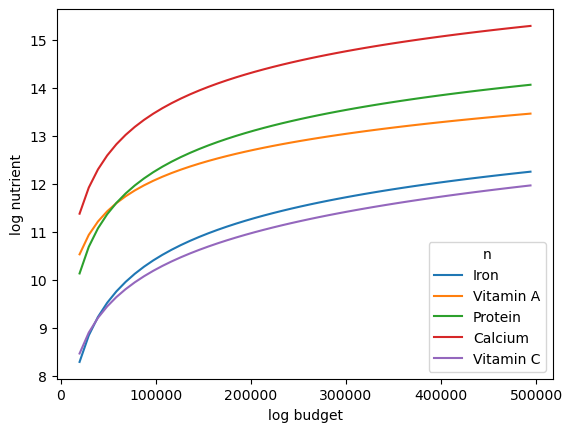

In [28]:
import numpy as np
import matplotlib.pyplot as plt

X = np.linspace(xref/5,xref*5,50)

#--------------------------
#ADD OR CHANGE NUTRIENTS HERE
#----------------------------
UseNutrients = ['Iron', 'Vitamin A', 'Protein', 'Calcium', 'Vitamin C']

df = pd.concat({myx:np.log(nutrient_demand(myx,pbar))[UseNutrients] for myx in X},axis=1).T
ax = df.plot()

ax.set_xlabel('log budget')
ax.set_ylabel('log nutrient')

Text(0, 0.5, 'log nutrient')

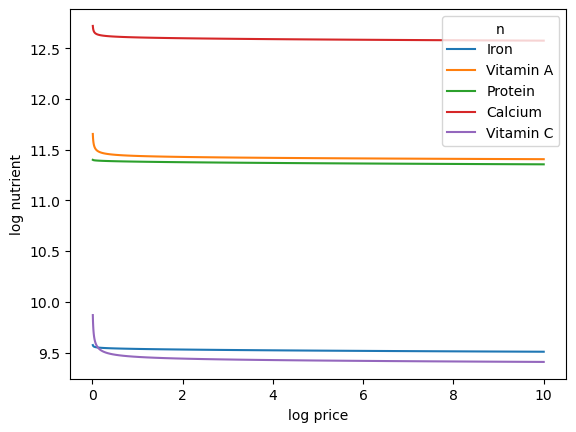

In [29]:
#--------------------------------------
#Pick a food high ion Vitamin A and Iron
#----------------------------------------

USE_GOOD = 'Dodo'

scale = np.geomspace(.01,10,50)

ndf = pd.DataFrame({s:np.log(nutrient_demand(xref/2,my_prices(USE_GOOD,pbar[USE_GOOD]*s)))[UseNutrients] for s in scale}).T

ax = ndf.plot()

ax.set_xlabel('log price')
ax.set_ylabel('log nutrient')

#### Nutritional Needs of Households

In [30]:
# In first round, averaged over households and villages
columns_to_average = [col for col in d.columns if col.startswith('Females') or col.startswith('Males')]

dbar = d[columns_to_average].mean()

In [31]:
rdi_renamed = rdi.copy()
rdi_renamed.columns = rdi_renamed.columns.to_series() \
    .str.replace('^F ', 'Females ', regex=True) \
    .str.replace('^M ', 'Males ', regex=True) \
    .str.replace('51\\+', '51-99', regex=True)

# Reorder columns to match dbar index
rdi_aligned = rdi_renamed[dbar.index]

# Matrix multiply
hh_rdi = rdi_aligned @ dbar   # example: for 7 days
hh_rdi

n
Energy          10179.623403
Protein           223.121385
Fiber             142.514728
Folate           1884.431742
Calcium          6265.332885
Carbohydrate      765.924681
Iron               62.606254
Magnesium        1602.030935
Niacin             72.034970
Phosphorus       4754.031607
Potassium       25390.080699
Riboflavin          5.636785
Thiamin             5.481473
Vitamin A        3757.061197
Vitamin B-12       11.306590
Vitamin B-6         6.200605
Vitamin C         333.589442
Vitamin E          70.216543
Vitamin K         444.909213
Zinc               45.674849
dtype: float64

# [A] Nutritional challeneges & Policy Goal

### use example costs notebook April 22nd

In [32]:
use_nutrients = nutrients.columns.intersection(hh_rdi.index.to_numpy())

nutrient_ratio = (nutrients[use_nutrients]/(hh_rdi[use_nutrients]*7)).dropna()

nutrient_ratio

,,n,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Niacin,Riboflavin,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Zinc
i,t,m,,,,,,,,,,,,,,,
1013000201,2009-10,Central,0.948354,0.953596,1.208902,1.050136,0.436820,2.071797,1.185074,0.908719,1.207164,1.084082,0.444976,0.776891,2.319631,2.917228,0.818969
1013000204,2009-10,Central,1.013364,0.923990,1.297503,1.115584,0.436215,2.329798,1.195615,0.979088,1.202776,1.177146,0.468511,0.662099,2.592948,3.433642,0.812684
1013000206,2009-10,Central,1.025440,1.002021,1.263760,1.180044,0.499379,1.933427,1.159917,0.881475,1.407537,1.018507,0.629893,1.002733,2.317165,3.539164,0.818007
101300021302,2009-10,Central,0.943181,0.980372,1.139307,1.053558,0.447254,1.910659,1.149515,0.872234,1.281540,1.051248,0.490588,0.955234,2.209014,2.745356,0.825096
1021000102,2009-10,Central,1.451331,1.314323,1.778458,1.503572,0.623865,3.011398,1.639006,1.315147,1.727812,1.492971,0.675517,1.213199,3.300215,4.299645,1.138763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4193003504,2009-10,Western,1.204475,1.268761,1.593419,1.208279,0.455653,3.270210,1.742723,1.279510,1.323252,1.788790,0.428938,0.682431,3.241755,4.708443,1.091887
4193003506,2009-10,Western,2.855179,2.739540,4.217164,3.267037,1.153567,7.526003,3.578744,3.089747,3.457587,3.971259,1.235746,2.164600,8.986093,13.146415,2.472091
4193003507,2009-10,Western,2.246162,2.310040,3.341205,2.508258,0.955641,5.895691,3.054334,2.412439,2.832142,3.072850,1.174561,1.479722,6.247353,10.269026,1.930446


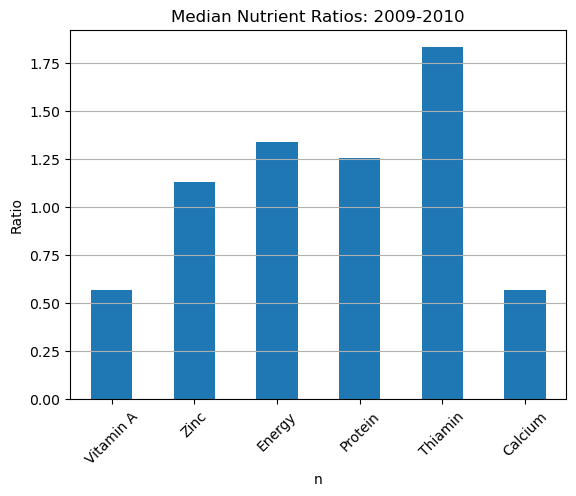

In [33]:
import matplotlib.pyplot as plt

selected_nutrients = ['Vitamin A','Zinc', 'Energy', 'Protein', 'Thiamin', 'Calcium']
nutrient_means = nutrient_ratio[nutrient_ratio[selected_nutrients] != 0][selected_nutrients].median()
nutrient_means.plot(kind='bar')
plt.title('Median Nutrient Ratios: 2009-2010')
plt.ylabel('Ratio')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout
plt.show()

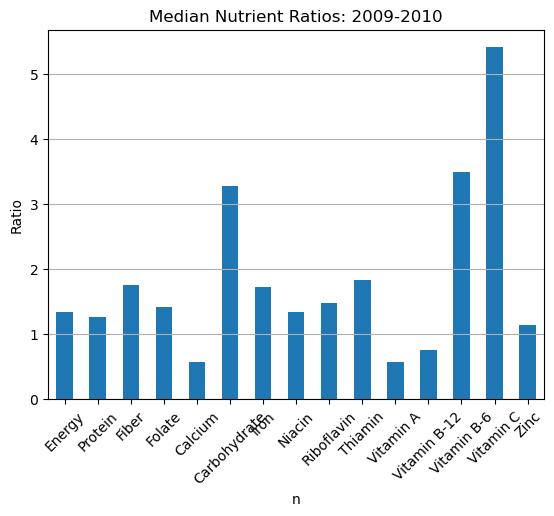

In [34]:
nutrient_means = nutrient_ratio[nutrient_ratio[use_nutrients] != 0][use_nutrients].median()
nutrient_means.plot(kind='bar')
plt.title('Median Nutrient Ratios: 2009-2010')
plt.ylabel('Ratio')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout
plt.show()

In [35]:
nutrients.index.get_level_values("m").unique()

Index(['Central', 'Eastern', 'Northern', 'Western'], dtype='object', name='m')

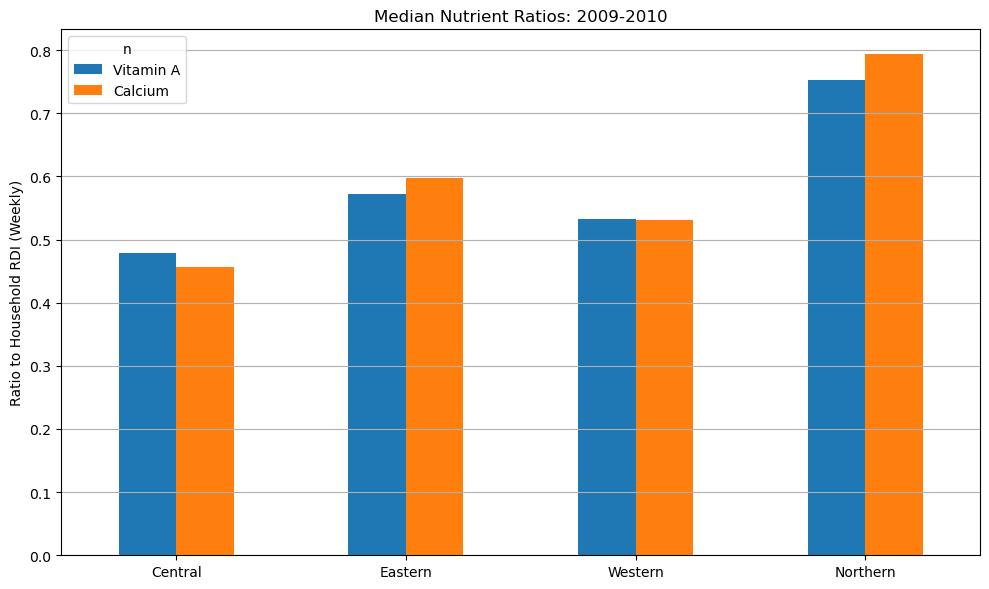

In [36]:
central_NR = (nutrients[nutrients.index.get_level_values("m") == "Central"][use_nutrients]/(hh_rdi[use_nutrients]*7)).dropna()
east_NR = (nutrients[nutrients.index.get_level_values("m") == "Eastern"][use_nutrients]/(hh_rdi[use_nutrients]*7)).dropna()
west_NR = (nutrients[nutrients.index.get_level_values("m") == "Western"][use_nutrients]/(hh_rdi[use_nutrients]*7)).dropna()
north_NR = (nutrients[nutrients.index.get_level_values("m") == "Northern"][use_nutrients]/(hh_rdi[use_nutrients]*7)).dropna()


selected_nutrients = ['Vitamin A', 'Calcium']
nutrient_means_c = central_NR[central_NR[selected_nutrients] != 0][selected_nutrients].median()
nutrient_means_e = east_NR[east_NR[selected_nutrients] != 0][selected_nutrients].median()
nutrient_means_w = west_NR[west_NR[selected_nutrients] != 0][selected_nutrients].median()
nutrient_means_n = north_NR[north_NR[selected_nutrients] != 0][selected_nutrients].median()


# Combine all into one DataFrame
nutrient_df = pd.DataFrame({
    'Central': nutrient_means_c,
    'Eastern': nutrient_means_e,
    'Western': nutrient_means_w,
    'Northern': nutrient_means_n
})

# Transpose so regions are side-by-side for each nutrient
nutrient_df = nutrient_df.T

# Plot
ax = nutrient_df.plot(kind='bar', figsize=(10, 6))
ax.set_title('Median Nutrient Ratios: 2009-2010')
ax.set_ylabel('Ratio to Household RDI (Weekly)')
ax.set_xticklabels(nutrient_df.index, rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


# [B] Policy Options

### This policy subsidizes dodo, eggs, and passion fruits to increase Vitamin A consumption. We also tax sugar and bread to encourage consuming more of the Vitamin A goods. We will target the central, eastern, and western regions as they have lower Vitamin A consumption. 

In [37]:
xhat_2 = xhat[xhat.index.get_level_values("m") != "Northern"]

In [38]:
print(fct["Vitamin A"].sort_values().head(10))
print(fct["Vitamin A"].sort_values().tail(15))
col_prices_2 = p.mean(axis=0)

pbar_2 = col_prices_2.groupby(level='j').mean()

common_keys_2 = pbar_2.index.intersection(result.beta.index)
pbar_2 = pbar_2.loc[common_keys_2]
pbar_2 = pbar_2.replace(np.nan, 1)

pbar_2["Dodo"] = pbar_2["Dodo"] * 0.3
pbar_2["Eggs"] = pbar_2["Eggs"] * 0.2
pbar_2["Passion Fruits"] = pbar_2["Passion Fruits"] * 0.7
pbar_2["Sugar"] = pbar_2["Sugar"] * 1.3
pbar_2["Bread"] = pbar_2["Bread"] * 1.3

qhat_2 = (xhat_2.unstack('j')/pbar_2).dropna(how='all')

# Drop missing columns
qhat_2 = qhat_2.loc[:,qhat_2.count()>0]

j
Beans (dry)          0
Beans (fresh)        0
Beef                 0
Beef (roasted)       0
Biscuits             0
Beef Offal           0
Bread                0
Chapati              0
Eggs (white yolk)    0
Garlic               0
Name: Vitamin A, dtype: int64
j
Eggs                               1400
Dodo                               1460
Sweet Potatoes (fresh)             2250
Milk (powdered)                    2570
Pumpkins                           3690
Eggs (yellow yolk)                 3810
Sweet Potatoes (dry)               4960
Sweet Potatoes (flour)             4960
Sweet Potatoes (orange, fresh)     6300
Carrots                            8350
Ghee                               8400
Sweet Potatoes (orange, flour)    13900
Sweet Potatoes (orange, dry)      13900
Beef Liver                        49680
Goat Liver                        73910
Name: Vitamin A, dtype: int64


In [39]:
use_2 = fct.index.intersection(qhat_2.columns)
nutrients_2 = qhat_2[use_2]@fct.loc[use_2,:]
nutrients_2.mean()   
fct1,c1= fct.align(qhat.T,axis=0,join='inner')
print(fct1.index)
N1 = fct1.T@c1


use_nutrients_2 = nutrients_2.columns.intersection(hh_rdi.index.to_numpy())

nutrient_ratio_2 = (nutrients_2[use_nutrients_2]/(hh_rdi[use_nutrients]*7)).dropna()

nutrient_ratio_2

Index(['Beans (dry)', 'Beans (fresh)', 'Beef', 'Bread', 'Cassava (fresh)',
       'Cooking Oil', 'Dodo', 'Eggs', 'Fresh Fish', 'Ground Nuts (pounded)',
       'Ground Nuts (shelled)', 'Mangos', 'Millet', 'Onions', 'Oranges',
       'Passion Fruits', 'Sim Sim', 'Sorghum', 'Sugar', 'Sweet Bananas',
       'Sweet Potatoes (fresh)', 'Tomatoes'],
      dtype='object', name='j')


,,n,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Niacin,Riboflavin,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Zinc
i,t,m,,,,,,,,,,,,,,,
1013000201,2009-10,Central,0.715062,1.279893,0.828654,0.973670,0.473709,1.160774,1.233451,0.644486,1.775934,0.762845,0.908582,1.738787,1.259022,2.411661,0.811667
1013000204,2009-10,Central,0.679359,1.065151,0.844055,0.960835,0.474433,1.237897,1.137558,0.675854,1.512763,0.746447,0.848225,1.283712,1.287859,2.739878,0.726590
1013000206,2009-10,Central,0.836923,1.546664,1.007064,1.271270,0.613812,1.185498,1.415461,0.676616,2.315051,0.828911,1.269915,2.312346,1.519997,3.628988,0.929954
101300021302,2009-10,Central,0.734734,1.445000,0.770474,1.050673,0.492541,1.028864,1.259054,0.601948,2.064574,0.764082,1.033103,2.196401,1.286996,2.267231,0.869750
1021000102,2009-10,Central,1.061510,1.704659,1.418696,1.409377,0.688283,1.716807,1.739731,0.979843,2.458393,1.004217,1.329054,2.342921,1.810678,3.825194,1.100468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4193003503,2009-10,Western,1.153925,1.991268,1.418280,1.642135,0.738831,2.019496,1.914476,1.176459,2.721125,1.365173,1.377615,2.589699,2.242674,4.446399,1.318610
4193003504,2009-10,Western,0.590067,1.090601,0.619112,0.731210,0.347564,1.091476,1.088880,0.588720,1.335206,0.712623,0.621046,1.256118,0.977361,1.531597,0.710822
4193003506,2009-10,Western,1.412204,2.296817,1.794703,2.210041,1.054835,2.437352,2.374860,1.476307,3.216926,1.596125,1.742963,2.963986,2.830235,6.260039,1.633450


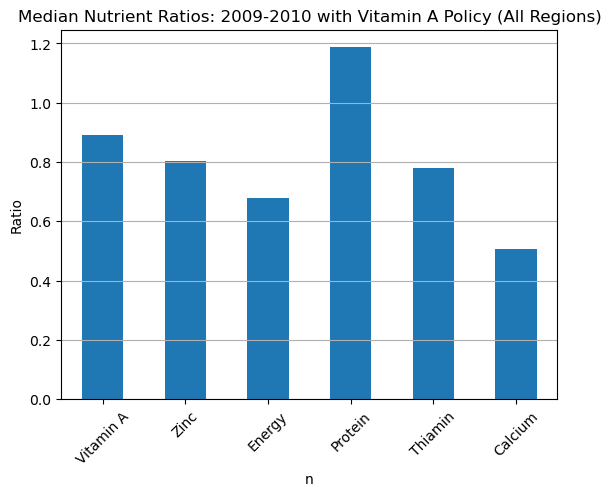

In [40]:
import matplotlib.pyplot as plt

selected_nutrients = ['Vitamin A','Zinc', 'Energy', 'Protein', 'Thiamin', 'Calcium']
nutrient_means_2 = nutrient_ratio_2[nutrient_ratio_2[selected_nutrients] != 0][selected_nutrients].median()
nutrient_means_2.plot(kind='bar')
plt.title('Median Nutrient Ratios: 2009-2010 with Vitamin A Policy (All Regions)')
plt.ylabel('Ratio')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout
plt.show()

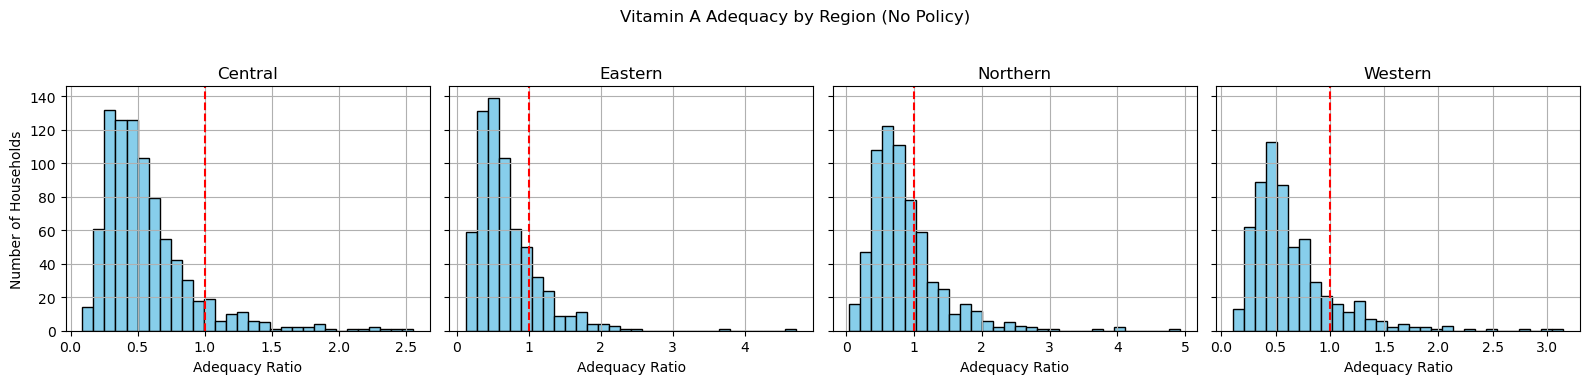

In [41]:
import matplotlib.pyplot as plt

# get the list of regions
regions = nutrient_ratio.index.get_level_values('m').unique().tolist()

# make one histogram per region, side by side
fig, axes = plt.subplots(
    nrows=1, 
    ncols=len(regions), 
    figsize=(4*len(regions), 4), 
    sharey=True
)

for ax, region in zip(axes, regions):
    # slice out just that region
    ca = nutrient_ratio.xs(region, level='m')['Vitamin A']
    
    # plot
    ca.hist(
        ax=ax, 
        bins=30, 
        color='skyblue', 
        edgecolor='black'
    )
    ax.axvline(1, color='red', linestyle='--')
    ax.set_title(region)
    ax.set_xlabel('Adequacy Ratio')
    if ax is axes[0]:
        ax.set_ylabel('Number of Households')

plt.suptitle('Vitamin A Adequacy by Region (No Policy)')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

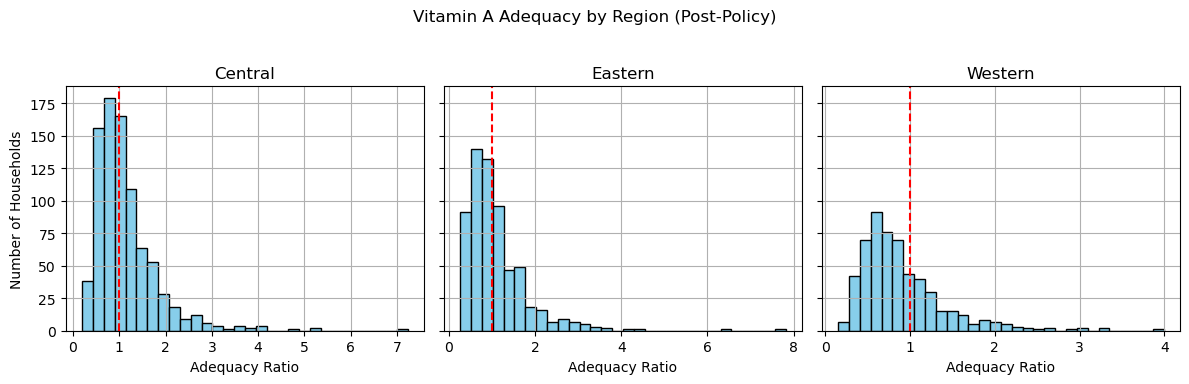

In [42]:
# make one histogram per region, side by side
regions = nutrient_ratio_2.index.get_level_values('m').unique().tolist()
fig, axes = plt.subplots(
    nrows=1, 
    ncols=len(regions), 
    figsize=(4*len(regions), 4), 
    sharey=True
)

for ax, region in zip(axes, regions):
    # slice out just that region
    ca = nutrient_ratio_2.xs(region, level='m')['Vitamin A']
    
    # plot
    ca.hist(
        ax=ax, 
        bins=30, 
        color='skyblue', 
        edgecolor='black'
    )
    ax.axvline(1, color='red', linestyle='--')
    ax.set_title(region)
    ax.set_xlabel('Adequacy Ratio')
    if ax is axes[0]:
        ax.set_ylabel('Number of Households')

plt.suptitle('Vitamin A Adequacy by Region (Post-Policy)')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

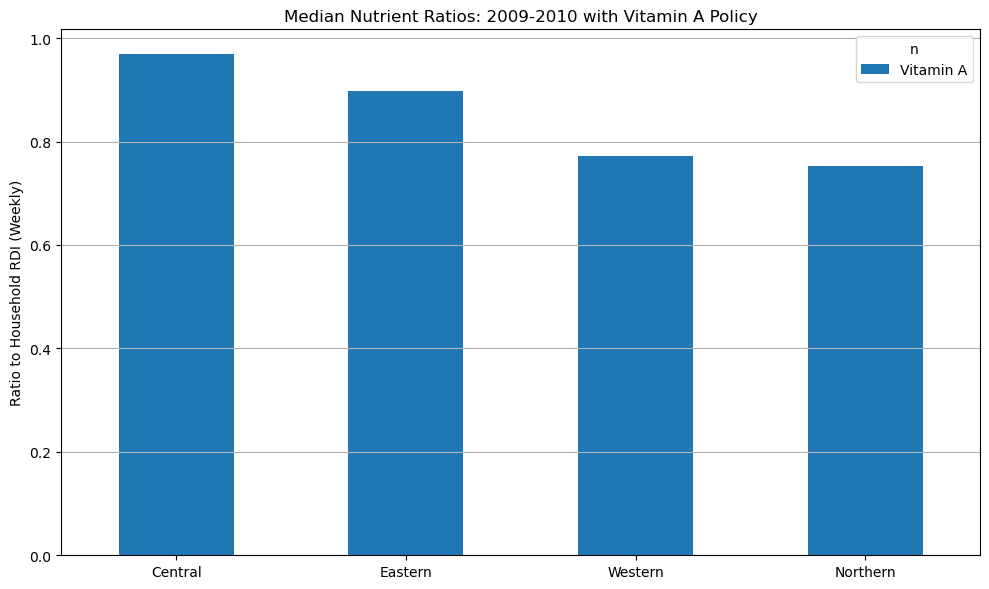

In [43]:
central_NR = (nutrients_2[nutrients_2.index.get_level_values("m") == "Central"][use_nutrients]/(hh_rdi[use_nutrients]*7)).dropna()
east_NR = (nutrients_2[nutrients_2.index.get_level_values("m") == "Eastern"][use_nutrients]/(hh_rdi[use_nutrients]*7)).dropna()
west_NR = (nutrients_2[nutrients_2.index.get_level_values("m") == "Western"][use_nutrients]/(hh_rdi[use_nutrients]*7)).dropna()
north_NR = (nutrients[nutrients.index.get_level_values("m") == "Northern"][use_nutrients]/(hh_rdi[use_nutrients]*7)).dropna()


selected_nutrients = ['Vitamin A']
nutrient_means_c = central_NR[central_NR[selected_nutrients] != 0][selected_nutrients].median()
nutrient_means_e = east_NR[east_NR[selected_nutrients] != 0][selected_nutrients].median()
nutrient_means_w = west_NR[west_NR[selected_nutrients] != 0][selected_nutrients].median()
nutrient_means_n = north_NR[north_NR[selected_nutrients] != 0][selected_nutrients].median()


# Combine all into one DataFrame
nutrient_df = pd.DataFrame({
    'Central': nutrient_means_c,
    'Eastern': nutrient_means_e,
    'Western': nutrient_means_w,
    'Northern': nutrient_means_n
})

# Transpose so regions are side-by-side for each nutrient
nutrient_df = nutrient_df.T

# Plot
ax = nutrient_df.plot(kind='bar', figsize=(10, 6))
ax.set_title('Median Nutrient Ratios: 2009-2010 with Vitamin A Policy')
ax.set_ylabel('Ratio to Household RDI (Weekly)')
ax.set_xticklabels(nutrient_df.index, rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


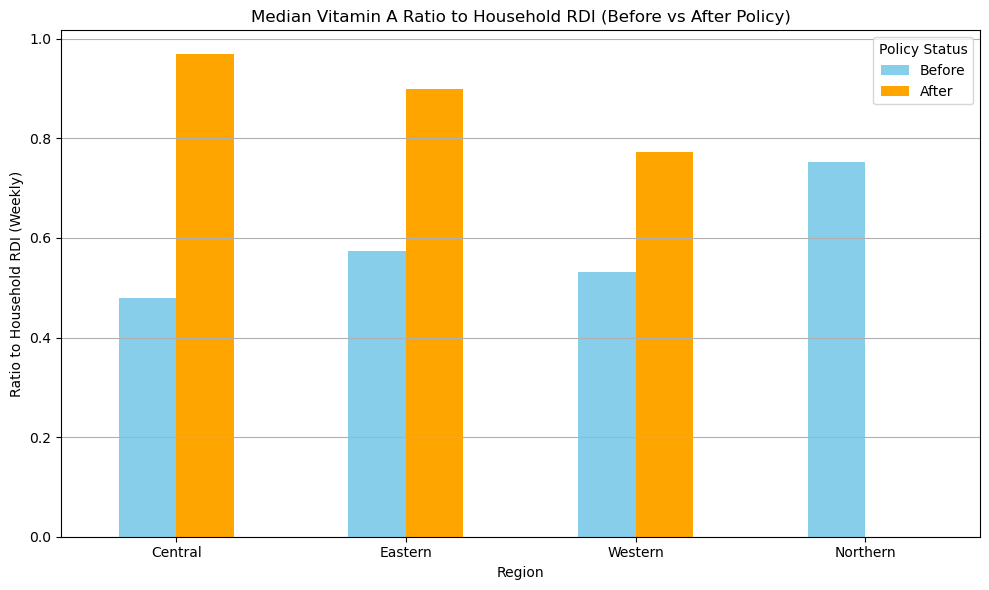

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

# === BEFORE DATA (as you already computed earlier) ===
central_before = (nutrients[nutrients.index.get_level_values("m") == "Central"][use_nutrients]/(hh_rdi[use_nutrients]*7)).dropna()
east_before = (nutrients[nutrients.index.get_level_values("m") == "Eastern"][use_nutrients]/(hh_rdi[use_nutrients]*7)).dropna()
west_before = (nutrients[nutrients.index.get_level_values("m") == "Western"][use_nutrients]/(hh_rdi[use_nutrients]*7)).dropna()
north_before = (nutrients[nutrients.index.get_level_values("m") == "Northern"][use_nutrients]/(hh_rdi[use_nutrients]*7)).dropna()

selected_nutrients = ['Vitamin A']

before_c = central_before[central_before[selected_nutrients] != 0][selected_nutrients].median()
before_e = east_before[east_before[selected_nutrients] != 0][selected_nutrients].median()
before_w = west_before[west_before[selected_nutrients] != 0][selected_nutrients].median()
before_n = north_before[north_before[selected_nutrients] != 0][selected_nutrients].median()

before_df = pd.DataFrame({
    'Central': before_c,
    'Eastern': before_e,
    'Western': before_w,
    'Northern': before_n
}).T
before_df.columns = ['Before']

# === AFTER DATA ===
central_after = (nutrients_2[nutrients_2.index.get_level_values("m") == "Central"][use_nutrients]/(hh_rdi[use_nutrients]*7)).dropna()
east_after = (nutrients_2[nutrients_2.index.get_level_values("m") == "Eastern"][use_nutrients]/(hh_rdi[use_nutrients]*7)).dropna()
west_after = (nutrients_2[nutrients_2.index.get_level_values("m") == "Western"][use_nutrients]/(hh_rdi[use_nutrients]*7)).dropna()
north_after = (nutrients_2[nutrients_2.index.get_level_values("m") == "Northern"][use_nutrients]/(hh_rdi[use_nutrients]*7)).dropna()

after_c = central_after[central_after[selected_nutrients] != 0][selected_nutrients].median()
after_e = east_after[east_after[selected_nutrients] != 0][selected_nutrients].median()
after_w = west_after[west_after[selected_nutrients] != 0][selected_nutrients].median()
after_n = north_after[north_after[selected_nutrients] != 0][selected_nutrients].median()

after_df = pd.DataFrame({
    'Central': after_c,
    'Eastern': after_e,
    'Western': after_w,
    'Northern': after_n
}).T
after_df.columns = ['After']

# === COMBINE BEFORE AND AFTER ===
combined_df = before_df.join(after_df)

# === PLOT ===
ax = combined_df.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'orange'])
ax.set_title('Median Vitamin A Ratio to Household RDI (Before vs After Policy)')
ax.set_ylabel('Ratio to Household RDI (Weekly)')
ax.set_xlabel('Region')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.legend(title='Policy Status')
plt.tight_layout()
plt.show()


# [C] Policy Costs

In [170]:
qhat_3 = qhat[qhat.index.get_level_values("m") != "Northern"]

In [171]:
((qhat_2["Dodo"].sum()) * (pbar["Dodo"] - pbar_2["Dodo"]) / 3662.20 +
 (qhat_2["Passion Fruits"].sum()) * (pbar["Passion Fruits"] - pbar_2["Passion Fruits"]) / 3662.20 +
(qhat_2["Eggs"].sum()) * (pbar["Eggs"] - pbar_2["Eggs"]) / 3662.20 + 
((qhat_2["Sugar"].sum()) * (pbar["Sugar"] - pbar_2["Sugar"]) / 3662.20) +
(qhat_2["Bread"].sum()) * (pbar["Bread"] - pbar_2["Bread"]) / 3662.20)

np.float64(4752.074190007557)

In [172]:
4752.074190007557 / 2670 # cost per household per week
(4752.074190007557 / 2670) / 7 * 32400000 #divided by average household size in 2010 and population in 2010

8237945.626337338

### Policy Cost: 4,752 USD total per week for all the households in the study
### To implement the policy throughout Uganda the cost would be 8,237,946 USD